# SRGAN을 활용한 고해상도 이미지 만들기

|평가문항|상세기준|
|---|---|
|1. SRGAN을 이용해 고해상도의 이미지를 생성하였다.|SRGAN을 통해 생성된 이미지를 제출하였다.|
|2. 다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation생성본을 비교분석하였다.|이미지의 특성과 super resolution 방법을 관련지어 생성 결과를 체계적으로 분석하였다.|
|3. 저해상도 gif 동영상을 고해상도 동영상으로 성공적으로 변환하였다.|저해상도 원본 gif와 생성된 고해상도 gif의 해상도 차이가 시각적으로 확인 가능하다.|

# 프로젝트 1: 직접 고른 이미지로 SRGAN 실험하기

# 프로젝트 1-1.
1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. `cv2.resize()`를 사용해 봅시다.
3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 `apply_srgan` 함수를 사용하면 쉽습니다.
4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 `cv2.resize()`를 사용해 봅시다.
5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

In [1]:
import os
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

(453, 680, 3)


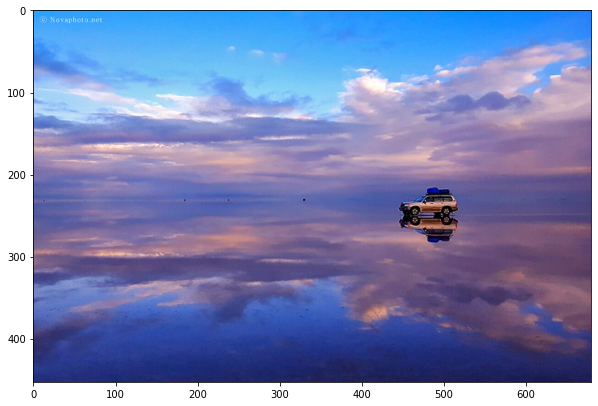

In [2]:
hr_image = cv2.imread(os.getenv('HOME') + '/aiffel/super_resolution/discovery_20170323_6362582542365564194.jpg')
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

print(hr_image.shape)

plt.figure(figsize=(10,8))
plt.imshow(hr_image)

(113, 170, 3)


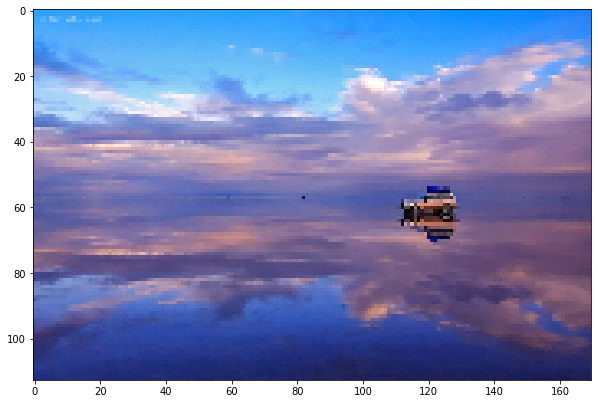

In [3]:
lr_image = cv2.resize(hr_image, 
                      dsize=(hr_image.shape[1]//4, hr_image.shape[0]//4))

print(lr_image.shape)

plt.figure(figsize=(10,8))
plt.imshow(lr_image)

In [4]:
# 미리 학습된 모델 불러오기
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [5]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr_image) # lr_image로 변경

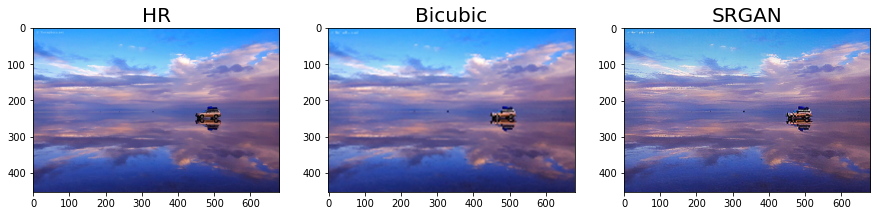

In [6]:
# Bicubic
def re_upsample(image):
    upsample = cv2.resize(
        lr_image,
        dsize=(hr_image.shape[1], hr_image.shape[0]),
        interpolation=cv2.INTER_CUBIC
    )
    return upsample

images = [hr_image, re_upsample(lr_image), srgan_hr]
titles = ['HR','Bicubic','SRGAN']

plt.figure(figsize=(15,10))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

단순히 전체 이미지를 봐서는 확인하기 어렵다.
그래서 전체 이미지에서 부분을 잘라서 확인하면 특징을 찾을 수 있다.

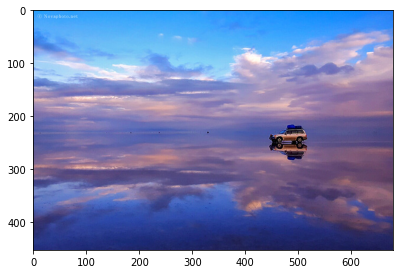

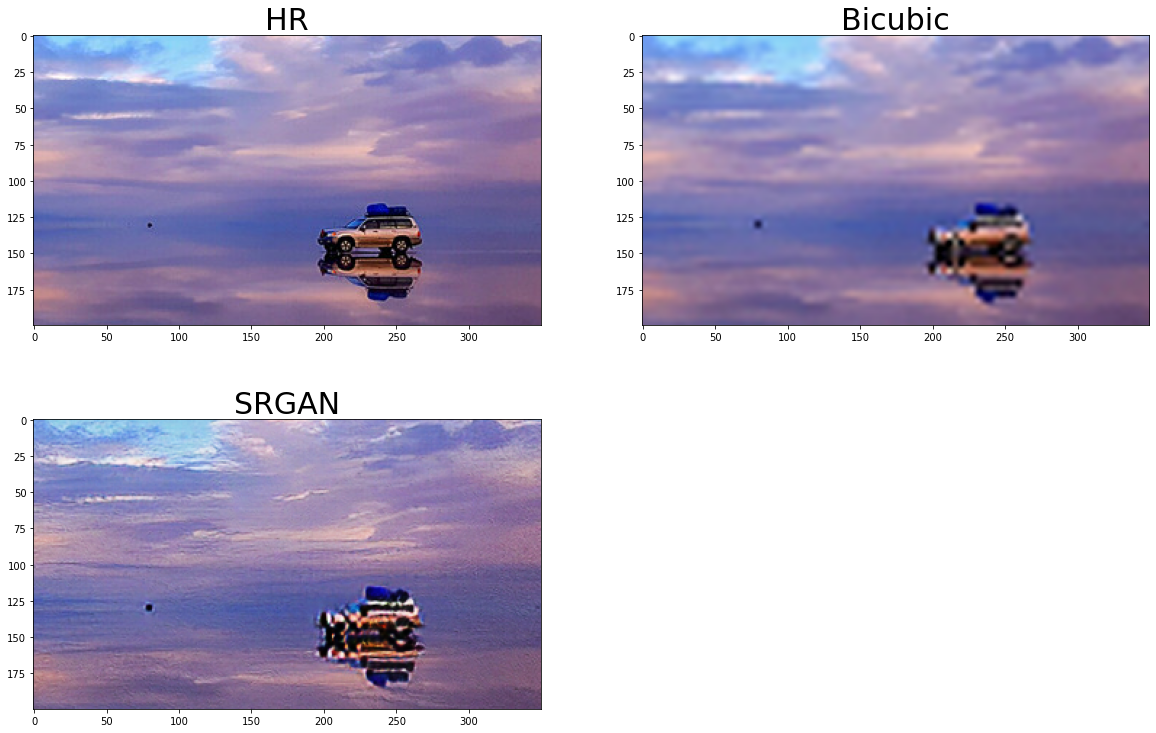

In [7]:
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


# 전체 이미지를 시각화합니다.
plt.figure(figsize=(20,15))
plt.subplot(311); plt.imshow(hr_image)

images = [hr_image, re_upsample(lr_image), srgan_hr]
titles = ['HR','Bicubic','SRGAN']

left_top = (100, 250) # 잘라낼 부분 좌표지정

plt.figure(figsize=(20,20))
for i, pind in enumerate([321, 322, 323]):
    plt.subplot(pind)
    plt.imshow(crop(images[i], left_top, 200, 350))
    plt.title(titles[i], fontsize=30)

이미지를 잘라서 확인하면 다음과 같이 확인할 수 있다.
* HR은 원본 고해상도
* bilinear interpolation으로 계산되었다. 값을 확장(넓혀서)한 상태에서 보간을 했기때문에 전체 이미지를 확대해서 보면 해상도가 떨어질 수 밖에 없는 것 같다.
* SRGAN은 AI가 만들어냈기 때문인지 HR보다 매끄럽진 못한 것 같다.

# 프로젝트 1-2.
1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 `apply_srgan` 함수를 사용하면 쉽습니다.
3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. `cv2.resize()`를 사용해 봅시다.
4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

(453, 680, 3)


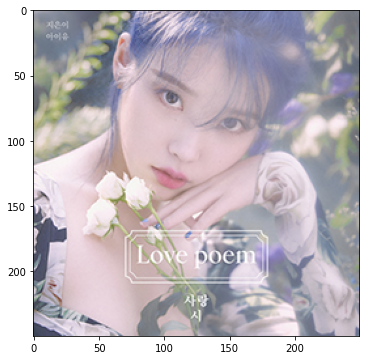

In [8]:
low_image = cv2.imread(os.getenv('HOME') + '/aiffel/super_resolution/IU_Love_poem.jpg')
low_image = cv2.cvtColor(low_image, cv2.COLOR_BGR2RGB)

print(hr_image.shape)

plt.figure(figsize=(8, 6))
plt.imshow(low_image)

In [9]:
# 위에서 만든 srgan_hr을 사용하여 고해상도로 변경
srgan_hr = apply_srgan(low_image) 

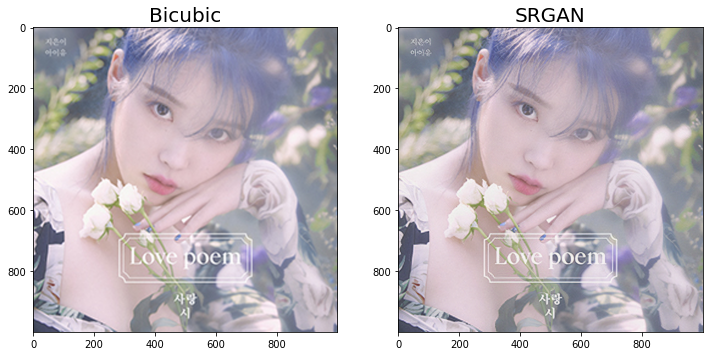

In [10]:
# 위에서 함수를 잘못 정의해서 다시 bicubic interpolation을 만든다.
bicubic_hr = cv2.resize(low_image, 
    dsize=(low_image.shape[1]*4, low_image.shape[0]*4), # 루브릭 조건 4배 늘리기
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

# 시각화
images = [bicubic_hr, srgan_hr]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(12, 12))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 2, i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

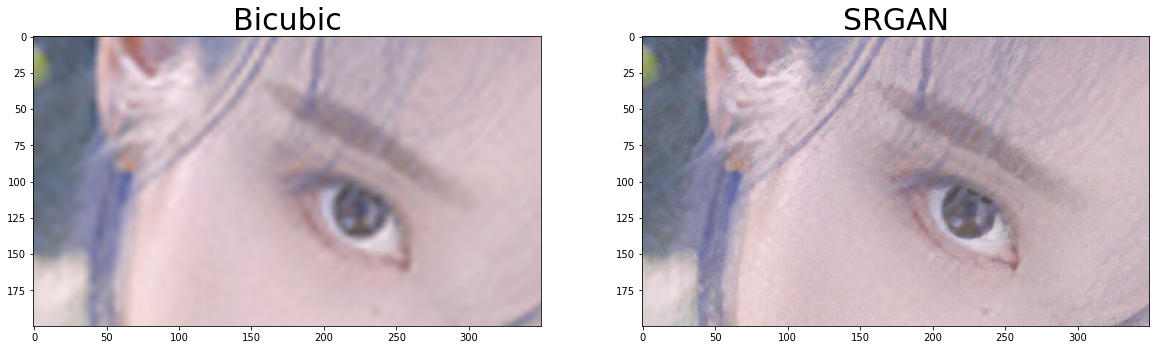

In [11]:
# 시각화를 통한 확인
images = [bicubic_hr, srgan_hr]
titles = ['Bicubic','SRGAN']

left_top = (150, 200) # 잘라낼 부분 좌표지정

plt.figure(figsize=(20,20))
for i, pind in enumerate([321, 322]):
    plt.subplot(pind)
    plt.imshow(crop(images[i], left_top, 200, 350))
    plt.title(titles[i], fontsize=30)

Bicubic은 옅고 흐린듯하다면 SRGAN은 보다 선명하고 명암이 조금 더 살아나는 것 같다. 얼굴의 윤곽쪽이 Bicubic보다 잘 살아나서 확대해서 볼 때는 SRGAN이 좀 더 나아보인다.전체 이미지는 별 차이를 느끼지 못했다.

---

# 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기
* 이미 학습된 SRGAN을 이용해 저해상도 영상을 고해상도 영상으로 바꾸기
* 이전에 사용했던 SRGAN을 이용해 한 프레임씩 고해상도 이미지로 변환 시켜 모든 프레임에 대해 적용하고 그 프레임을 합쳐 동영상으로 만들기

# 1. gif 파일 불러오기
아래 주소에 몇 개의 gif 파일이 있습니다. 이 중 하나를 골라 다운 로드하여 아래 과정을 수행합시다. (한 개 이상의 gif 파일에 대해 아래 과정을 수행해야 합니다!)

GIF files [https://drive.google.com/drive/folders/1OLsa4btdwNUiVJcOJgZe_C6-lwEoNr4e](https://drive.google.com/drive/folders/1OLsa4btdwNUiVJcOJgZe_C6-lwEoNr4e)

다운받은 gif 파일을 아래와 같은 과정을 통해 각 프레임(이미지)을 불러올 수 있습니다. `frames`이란 리스트 안에 각각의 프레임이 들어 있습니다.

In [12]:
# 다운받은 파일의 경로를 설정해 주세요.
path = os.getenv('HOME') + '/aiffel/super_resolution'
gif = cv2.VideoCapture(os.path.join(path, "book_lr.gif"))

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 22
frame 크기 : (215, 380, 3)


# 2. 프레임별 Super Resolution 진행하기
Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘려봅시다. Super Resolution이 완료된 각각의 결과를 frames_sr이라는 리스트에 넣어주세요.

In [13]:
# numpy array
print(type(frame))
print(type(frames))

<class 'NoneType'>
<class 'list'>


In [14]:
frames_sr_bi = []
for frame in frames:
    frames_sr_bi.append(cv2.resize(frame,
                                   dsize=(frame.shape[1]*4, frame.shape[0]*4),
                                   interpolation=cv2.INTER_CUBIC
                                  ))

In [15]:
frames_sr_sr = []   
for frame in frames:   
    frames_sr_sr.append(apply_srgan(frame))

* list이기 때문에 기존의 코드를 변형해야한다.
* gif는 사진이 여러개있다고 생각하면 되기 때문에 각 사진을 resize 하기 위해서는 반복적인 배열에 반복문으로 접근하면 된다. 비어있는 list안에 append로 frames_sr에 채워준다.

# 3. 프레임을 합쳐 gif 만들기
위에서 frame_sr을 만들었다면 아래 코드와 같이 gif 파일을 생성할 수 있습니다. Bicubic 및 SRGAN의 결과를 각각 저장하여 2개 파일을 만들어 주세요.

In [ ]:
imageio.mimsave(os.path.join(path, 'book_bicubic.gif'), frames_sr_bi)
imageio.mimsave(os.path.join(path, 'book_srgan.gif'), frames_sr_sr)

# 4. jupyter notebook에 git 표시하기
아래와 같이 다운받은 저해상도 gif 파일과 고해상도 gif 파일을 각각 jupyter 내에 출력하여 최종 제출해 주시면 됩니다. jupyter 내에 출력이 어려운 경우, GitHub에 저해상도, 고해상도 gif파일을 업로드 후 링크를 첨부해주시기바랍니다. Super Resolution이 잘 적용되었는지 시각적으로 확인하기 위해 아래의 width 옵션을 적당히 크게 해주세요. 저해상도 및 고해상도 시각화의 width 값은 같도록 설정해주세요.

In [ ]:
# from IPython.display import Image

# Image(open('book_bicubic.gif','rb').read(), width=450) # 학습 진행 결과

In [ ]:
# Image(open('book_srgan.gif','rb').read(), width=450) # 학습 진행 결과

용량이 너무 큰 관계로 구글 드라이브를 통해 이미지 확인 부탁드립니다.
* [Google Drive gif upload](https://drive.google.com/drive/u/0/folders/1PvNKO7sBxDTMYqzAF7rDGo75F2ThU6j4)